# GANs my implementations

In [1]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Model inputs

In [3]:
def model_inputs(real_dim, z_dim):
    # Discriminator inputs
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="input_real")
    
    # Generator inputs
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    
    return inputs_real, inputs_z

## Generator Network
![GAN Network](gan_mnist/assets/gan_network.png)

#### Variable Scope
Use tf.variable_scope <b> for 2 reasons </b>:
<ul>
    <li> Make sure all varaibles names start with generator / discriminator (will help out later when training the separate networks </li>
    <li> Also want <b> to reuse these networks with different inputs </b></li>
        <ul>
            <li> For the generator: we're going to train it but also <b>sample from it as we're training after training </b> </li>
            <li> For the discriminator: need to share variables between the fake and real input images </li>
    </ul>
</ul>
<p> So we can use the reuse keyword to <b> tell TensorFlow to reuse the var instead of createing new one if we build the graph again</b></p>

#### Leaky ReLU
Avoid gradient vanishing

#### Tanh Output
Generator has been found to perform the best <b> with tanh for the generator output </b>
<br>
This implies that <b> we have to rescale the MNIST images <b> to be between -1 and 1 instead of 0 and 1 </b>

In [4]:
def generator(z, output_dim, n_units = 128, reuse=False):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        output_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope("generator", reuse=reuse):
        # Hidden layer 
        h1 = tf.layers.dense(inputs = z,
                            units = n_units,
                            activation = None)
        
        # Batch normalization
        h1_batch = tf.layers.batch_normalization (h1)
        
        h1_out = tf.nn.leaky_relu(h1_batch)
        
        # Logits and tanh output
        logits = tf.layers.dense(inputs = h1_out,
                            units = output_dim,
                            activation = None)
        
        
        out = tf.tanh(logits)
        
        return out
        

## Discriminator
Same thing: except using <b> sigmoid output layer </b>

In [5]:
def discriminator(x, n_units=128, reuse=False):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse=reuse): 
        # Hidden layer
        h1 = tf.layers.dense(inputs = x,
                            units = n_units,
                            activation = None)
        
        # Batch normalization
        h1_batch = tf.layers.batch_normalization(h1)
        
        h1_out = tf.nn.leaky_relu(h1_batch)
        
        logits = tf.layers.dense(inputs = h1_out,
                                units = 1,
                                activation = None)
    
        out = tf.nn.softmax(logits)
        
        return out, logits

## Hyperparameters

In [6]:
# Size input image for discriminator
input_size = 784 # 28*28

# Size of latent vector to generator
z_size = 100

# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128

# Label smoothing
smooth = 0.1

## Build the network

In [7]:
tf.reset_default_graph()

# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size, n_units=g_hidden_size)
# g_model is the generator output

# Discriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size)
d_model_fake, d_logits_fake = discriminator(g_model, n_units=d_hidden_size, reuse=True)

## Discriminator and generator losses

We train the g and d <b> at the same time </b> so we need losses for <b> both networks </b>

#### Discriminator Loss
Sum of loss for real and fake images
<br>
d_loss = d_loss_real + d_loss_fake
<br><br>
The losses will by <b> sigmoid cross entropy + wrap with tf.reduce_mean to get the mean for all the images in the batch.
</b>

##### Real image loss
<ul>
    <li>Use `d_logits_real` and labels <b> are all 1 (since all real data is real) </b></li>
    <li>Label smoothing:  To help the discriminator generalize better, the labels are <b>reduced a bit from 1.0 to 0.9</b></li>

`labels = tf.ones_like(tensor) * (1 - smooth)`
For the real image loss, use the real logits and (smoothed) labels of ones. 
##### Fake image loss
<li>Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that</li>
For the fake image loss, use the fake logits with labels of all zeros

#### Generator Loss
The generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.

In [8]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

## Optimizers

<ul>
    <li>Update the generator and discriminator <b>separately</b></li>
    <li> So we need to get the var for each part : we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph. </li>
</ul>

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

# Optimizers
d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
batch_size = 100
epochs = 500
samples = []
losses = []

# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            
            # Create batch (image, label)
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            # batch[0]: image
            batch_images = batch[0].reshape((batch_size, 784))
            # Since we using tanh output on generator we scale -1, 1
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
            
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)   

Epoch 1/500... Discriminator Loss: 0.3914... Generator Loss: 6.2728
Epoch 2/500... Discriminator Loss: 0.6176... Generator Loss: 6.6474
Epoch 3/500... Discriminator Loss: 0.7979... Generator Loss: 6.0134
Epoch 4/500... Discriminator Loss: 0.8328... Generator Loss: 3.1351
Epoch 5/500... Discriminator Loss: 0.4083... Generator Loss: 4.9768
Epoch 6/500... Discriminator Loss: 0.3800... Generator Loss: 10.2947
Epoch 7/500... Discriminator Loss: 0.6862... Generator Loss: 2.0272
Epoch 8/500... Discriminator Loss: 0.5735... Generator Loss: 8.8016
Epoch 9/500... Discriminator Loss: 0.7243... Generator Loss: 3.1319
Epoch 10/500... Discriminator Loss: 0.9643... Generator Loss: 2.6018
Epoch 11/500... Discriminator Loss: 0.7666... Generator Loss: 4.1254
Epoch 12/500... Discriminator Loss: 0.7015... Generator Loss: 2.7135
Epoch 13/500... Discriminator Loss: 0.5655... Generator Loss: 4.4550
Epoch 14/500... Discriminator Loss: 0.8913... Generator Loss: 5.2318
Epoch 15/500... Discriminator Loss: 1.2002

Epoch 120/500... Discriminator Loss: 1.3256... Generator Loss: 1.6756
Epoch 121/500... Discriminator Loss: 1.0578... Generator Loss: 2.1507
Epoch 122/500... Discriminator Loss: 1.1687... Generator Loss: 1.5893
Epoch 123/500... Discriminator Loss: 1.1682... Generator Loss: 1.1772
Epoch 124/500... Discriminator Loss: 1.0437... Generator Loss: 1.5023
Epoch 125/500... Discriminator Loss: 1.3285... Generator Loss: 1.6368
Epoch 126/500... Discriminator Loss: 0.8180... Generator Loss: 2.1646
Epoch 127/500... Discriminator Loss: 1.1045... Generator Loss: 1.4339
Epoch 128/500... Discriminator Loss: 1.3379... Generator Loss: 1.3611
Epoch 129/500... Discriminator Loss: 1.0434... Generator Loss: 1.4660
Epoch 130/500... Discriminator Loss: 1.4767... Generator Loss: 0.9559
Epoch 131/500... Discriminator Loss: 0.9924... Generator Loss: 1.5059
Epoch 132/500... Discriminator Loss: 1.0640... Generator Loss: 1.5884
Epoch 133/500... Discriminator Loss: 1.3955... Generator Loss: 1.2253
Epoch 134/500... Dis

Epoch 238/500... Discriminator Loss: 1.0352... Generator Loss: 1.4807
Epoch 239/500... Discriminator Loss: 1.0126... Generator Loss: 1.4296
Epoch 240/500... Discriminator Loss: 1.1114... Generator Loss: 1.6775
Epoch 241/500... Discriminator Loss: 1.0734... Generator Loss: 1.4513
Epoch 242/500... Discriminator Loss: 1.0874... Generator Loss: 1.3895
Epoch 243/500... Discriminator Loss: 1.0237... Generator Loss: 1.5889
Epoch 244/500... Discriminator Loss: 0.9193... Generator Loss: 1.6499
Epoch 245/500... Discriminator Loss: 1.0289... Generator Loss: 1.5912
Epoch 246/500... Discriminator Loss: 1.0937... Generator Loss: 1.4082
Epoch 247/500... Discriminator Loss: 1.0000... Generator Loss: 1.5966
Epoch 248/500... Discriminator Loss: 1.2325... Generator Loss: 1.4735
Epoch 249/500... Discriminator Loss: 0.9871... Generator Loss: 1.6455
Epoch 250/500... Discriminator Loss: 1.1632... Generator Loss: 1.3131
Epoch 251/500... Discriminator Loss: 1.0390... Generator Loss: 1.4752
Epoch 252/500... Dis

Epoch 356/500... Discriminator Loss: 1.0298... Generator Loss: 1.6949
Epoch 357/500... Discriminator Loss: 0.9056... Generator Loss: 1.6985
Epoch 358/500... Discriminator Loss: 1.1070... Generator Loss: 1.9494
Epoch 359/500... Discriminator Loss: 0.9495... Generator Loss: 1.9848
Epoch 360/500... Discriminator Loss: 0.9740... Generator Loss: 1.6901
Epoch 361/500... Discriminator Loss: 0.8192... Generator Loss: 1.8258
Epoch 362/500... Discriminator Loss: 0.8441... Generator Loss: 2.0032
Epoch 363/500... Discriminator Loss: 0.9313... Generator Loss: 1.9378
Epoch 364/500... Discriminator Loss: 0.8320... Generator Loss: 1.9849
Epoch 365/500... Discriminator Loss: 1.0346... Generator Loss: 1.8632
Epoch 366/500... Discriminator Loss: 0.9469... Generator Loss: 1.7503
Epoch 367/500... Discriminator Loss: 0.9310... Generator Loss: 1.8307
Epoch 368/500... Discriminator Loss: 1.0380... Generator Loss: 1.9229
Epoch 369/500... Discriminator Loss: 0.9407... Generator Loss: 1.8843
Epoch 370/500... Dis

Epoch 474/500... Discriminator Loss: 1.0495... Generator Loss: 2.1830
Epoch 475/500... Discriminator Loss: 0.8997... Generator Loss: 2.1000
Epoch 476/500... Discriminator Loss: 1.0030... Generator Loss: 1.4626
Epoch 477/500... Discriminator Loss: 0.7855... Generator Loss: 2.3008
Epoch 478/500... Discriminator Loss: 0.8325... Generator Loss: 2.2889
Epoch 479/500... Discriminator Loss: 0.8944... Generator Loss: 1.8242
Epoch 480/500... Discriminator Loss: 0.8974... Generator Loss: 1.7088
Epoch 481/500... Discriminator Loss: 0.8688... Generator Loss: 2.0205
Epoch 482/500... Discriminator Loss: 0.9611... Generator Loss: 1.8622
Epoch 483/500... Discriminator Loss: 0.8870... Generator Loss: 1.7713
Epoch 484/500... Discriminator Loss: 0.8552... Generator Loss: 1.9080
Epoch 485/500... Discriminator Loss: 0.9355... Generator Loss: 1.7164
Epoch 486/500... Discriminator Loss: 0.7943... Generator Loss: 2.0081
Epoch 487/500... Discriminator Loss: 0.9295... Generator Loss: 1.7083
Epoch 488/500... Dis

## Training Loss

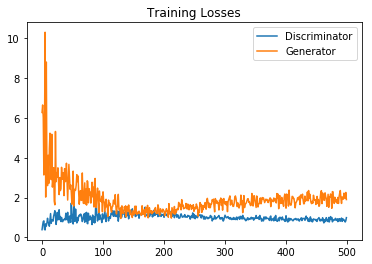

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

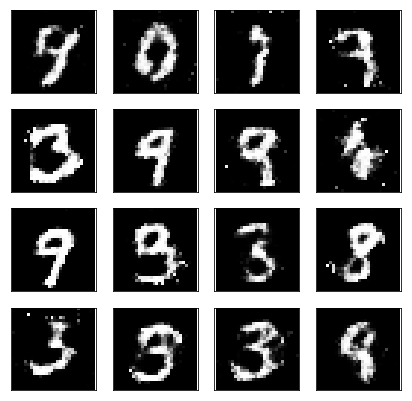

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
_ = view_samples(-1, samples)

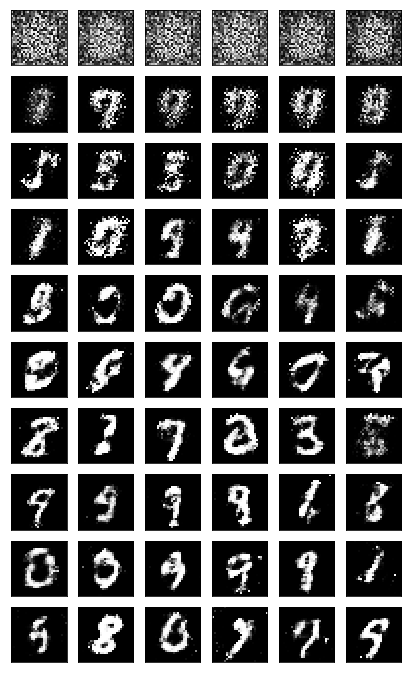

In [13]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

In [14]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


FailedPreconditionError: Attempting to use uninitialized value generator/batch_normalization/moving_mean
	 [[Node: generator/batch_normalization/moving_mean/read = Identity[T=DT_FLOAT, _class=["loc:@generator/batch_normalization/moving_mean"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](generator/batch_normalization/moving_mean)]]

Caused by op 'generator/batch_normalization/moving_mean/read', defined at:
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-9d725383868b>", line 7, in <module>
    g_model = generator(input_z, input_size, n_units=g_hidden_size)
  File "<ipython-input-4-afeaf5aa1f42>", line 23, in generator
    h1_batch = tf.layers.batch_normalization (h1)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\layers\normalization.py", line 774, in batch_normalization
    return layer.apply(inputs, training=training)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\layers\base.py", line 762, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\layers\base.py", line 636, in __call__
    self.build(input_shapes)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\layers\normalization.py", line 311, in build
    trainable=False)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\layers\base.py", line 504, in add_variable
    partitioner=partitioner)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1262, in get_variable
    constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1097, in get_variable
    constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 435, in get_variable
    constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 404, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 806, in _get_single_variable
    constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variables.py", line 229, in __init__
    constraint=constraint)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\variables.py", line 376, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\array_ops.py", line 127, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2728, in identity
    "Identity", input=input, name=name)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value generator/batch_normalization/moving_mean
	 [[Node: generator/batch_normalization/moving_mean/read = Identity[T=DT_FLOAT, _class=["loc:@generator/batch_normalization/moving_mean"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](generator/batch_normalization/moving_mean)]]
